Disciplina: Aprendizagem de Máquina Probabilística

Período: 2025.2

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 5 - Processos Gaussianos com Kernel RBF: Regressão Unidimensional e Maximização da Evidência

Questão 1 - Implemente um modelo de Processos Gaussianos com kernel RBF para tarefas de regressão unidimensional com ruído de observação Gaussiano. Implemente um procedimento de otimização dos hiperparâmetros do modelo (kernel e verossimilhança) via maximização da evidência.

- Treine o seu modelo com os dados do arquivo gp_data_train.csv fornecido.
- Teste o modelo resultante com os dados do arquivo gp_data_test.csv.
- Reporte os valores de RMSE e NLPD obtidos no treino e no teste.
- Faça o plot da curva predita, indicando a média ˆµ e a incerteza (ˆµ ± 2^σ) predita ao longo do intervalo [−1, 1] do domínio.
- Execute os itens anteriores considerando os primeiros 10, 30, 50, 75, 100 dados de treinamento fornecidos.

Observação: Na otimização dos hiperparâmetros, use métodos baseados em gradientes para facilitar sua implementação, como os do Scipy (https://docs.scipy.org/doc/scipy/reference/
generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

- Note que você precisará calcular os gradientes da evidência em relação aos hiperparâmetros.
- Opcionalmente, você pode usar o pacote Jax (https://github.com/google/jax) ou outro similar para calcular automaticamente os gradientes.
- O procedimento de otimização deve garantir que os hiperparâmetros são válidos, e.g., não permitir uma variância do ruído negativa.


=== Usando N = 10 dados de treino ===
  -> lengthscale = 0.1290
  -> variance = 0.1831
  -> noise_var = 0.0134
  -> RMSE Train = 0.0595
  -> RMSE Test  = 0.1893
  -> NLPD Train = -1.1743
  -> NLPD Test  = -0.1140


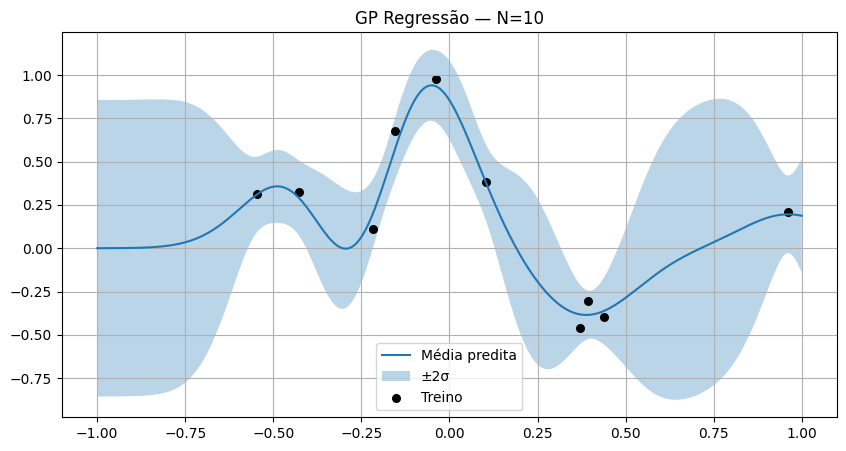


=== Usando N = 30 dados de treino ===
  -> lengthscale = 0.1638
  -> variance = 0.2088
  -> noise_var = 0.0116
  -> RMSE Train = 0.0865
  -> RMSE Test  = 0.1385
  -> NLPD Train = -0.6282
  -> NLPD Test  = -0.0874


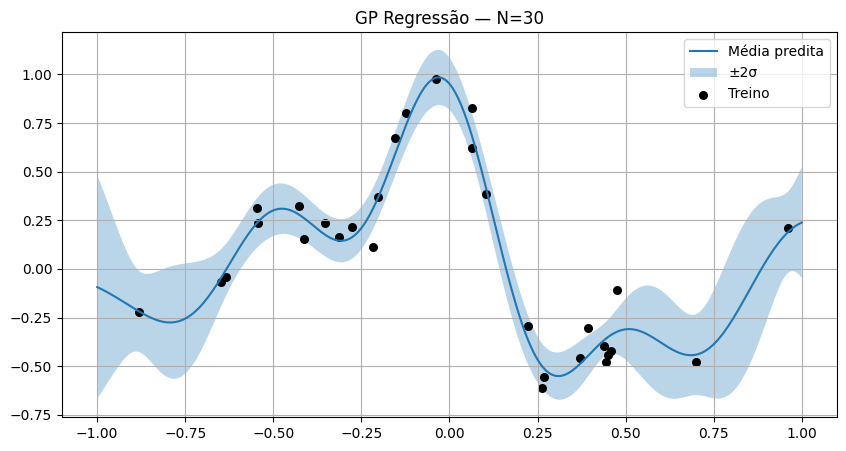


=== Usando N = 50 dados de treino ===
  -> lengthscale = 0.1531
  -> variance = 0.1927
  -> noise_var = 0.0118
  -> RMSE Train = 0.0937
  -> RMSE Test  = 0.1151
  -> NLPD Train = -0.1303
  -> NLPD Test  = -0.1086


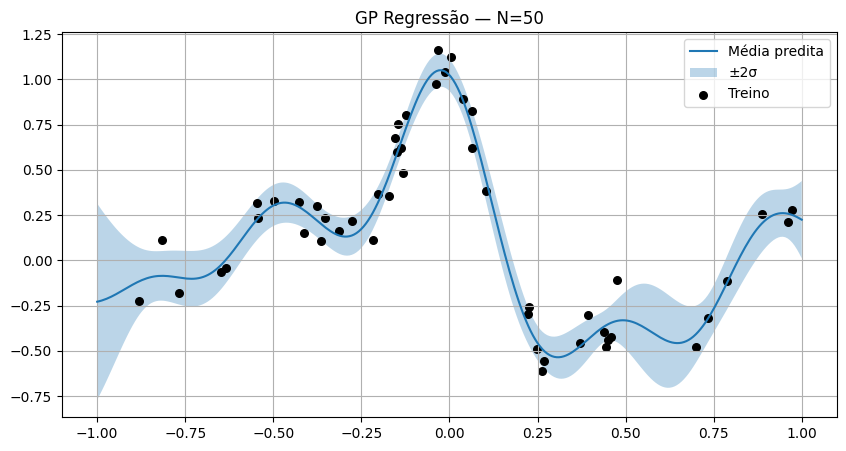


=== Usando N = 75 dados de treino ===
  -> lengthscale = 0.1598
  -> variance = 0.1987
  -> noise_var = 0.0102
  -> RMSE Train = 0.0910
  -> RMSE Test  = 0.1087
  -> NLPD Train = 0.4726
  -> NLPD Test  = 0.7566


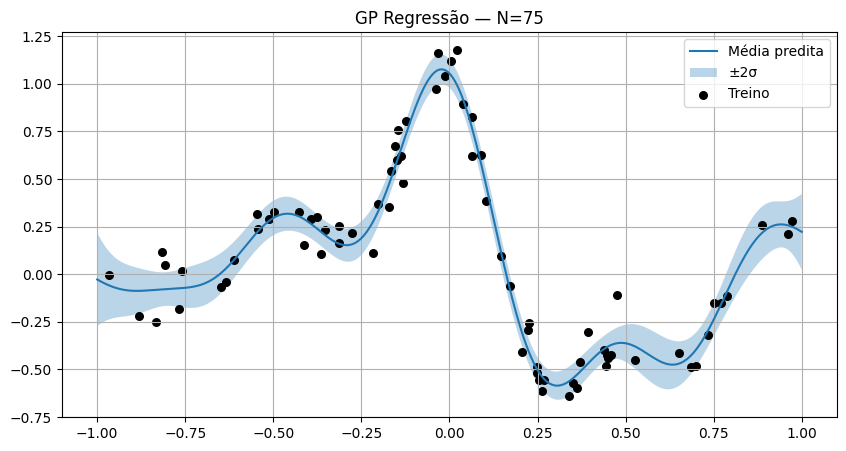


=== Usando N = 100 dados de treino ===
  -> lengthscale = 0.1619
  -> variance = 0.1979
  -> noise_var = 0.0102
  -> RMSE Train = 0.0937
  -> RMSE Test  = 0.1000
  -> NLPD Train = 1.1953
  -> NLPD Test  = 1.1534


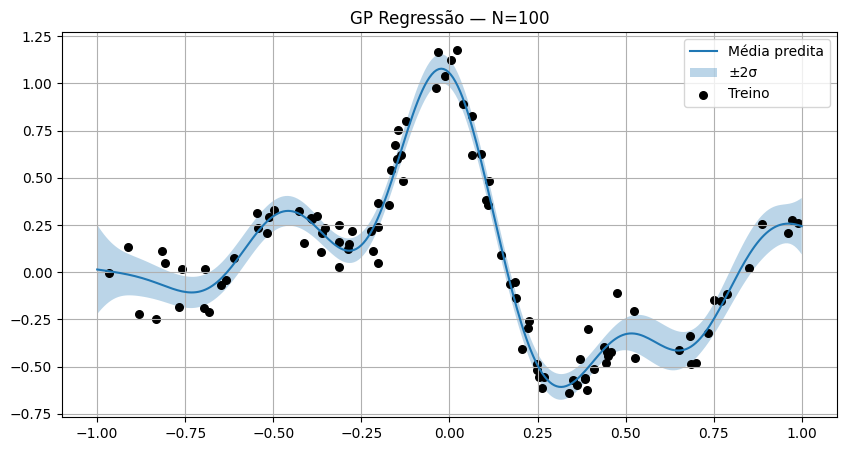

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# 1. Carregar dados
# ============================================================

train_data = np.genfromtxt('gp_data_train.csv', delimiter=',')
test_data  = np.genfromtxt('gp_data_test.csv', delimiter=',')

train_x = train_data[:, 0].reshape(-1, 1)
train_y = train_data[:, 1]

test_x = test_data[:, 0].reshape(-1, 1)
test_y = test_data[:, 1]

# ============================================================
# 2. Kernel RBF
# ============================================================

def rbf_kernel(x1, x2, lengthscale, variance):
  dists = np.sum((x1[:,None] - x2[None,:])**2, axis=2)
  return variance * np.exp(-0.5 * dists / (lengthscale**2))

# ============================================================
# 3. Log-marginal likelihood e gradientes
# ============================================================

def gp_neg_log_marginal_likelihood(params, X, y):
  lengthscale = np.exp(params[0])
  variance = np.exp(params[1])
  noise_var = np.exp(params[2])

  K = rbf_kernel(X, X, lengthscale, variance) + noise_var * np.eye(len(X))

  # Cholesky
  try:
    L = np.linalg.cholesky(K)
  except:
    return 1e10  # evita NaN

  # Garantir y como vetor 1D
  y = y.reshape(-1)

  # Resolver K^{-1} y
  alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))

  # log-marginal-likelihood (agora escalar)
  term1 = 0.5 * np.dot(y, alpha)
  term2 = np.sum(np.log(np.diag(L)))
  term3 = 0.5 * len(X) * np.log(2*np.pi)

  nll = term1 + term2 + term3
  return float(nll)

# ============================================================
# 4. Treinar GP via maximização da evidência
# ============================================================

def train_gp(X, y):
  init_params = np.log([1.0, 1.0, 0.1])

  res = minimize(
    fun=gp_neg_log_marginal_likelihood,
    x0=init_params,
    args=(X, y),
    method='L-BFGS-B'
  )

  l = np.exp(res.x[0])
  v = np.exp(res.x[1])
  s = np.exp(res.x[2])

  return l, v, s

# ============================================================
# 5. GP Predictive mean + variance
# ============================================================

def gp_predict(X, y, Xs, length, var, noise):
  y = y.reshape(-1)  # garante 1D
  K = rbf_kernel(X, X, length, var) + noise * np.eye(len(X))
  K_s  = rbf_kernel(X, Xs, length, var)
  K_ss = rbf_kernel(Xs, Xs, length, var)

  L = np.linalg.cholesky(K)
  alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))

  mu = K_s.T @ alpha

  v = np.linalg.solve(L, K_s)
  cov = K_ss - v.T @ v

  return mu, np.diag(cov)

# ============================================================
# 6. Métricas RMSE e NLPD
# ============================================================

def rmse(y, mu):
  return np.sqrt(np.mean((y - mu)**2))

def nlpd(y, mu, var):
  return np.mean(0.5*np.log(2*np.pi*var) + 0.5*((y - mu)**2)/var)

# ============================================================
# 7. Loop: usar 10, 30, 50, 75, 100 dados
# ============================================================

sizes = [10, 30, 50, 75, 100]

for N in sizes:
  print(f"\n=== Usando N = {N} dados de treino ===")

  X_sub = train_x[:N]
  y_sub = train_y[:N]

  # Treinar GP
  length, variance, noise = train_gp(X_sub, y_sub)

  print(f"  -> lengthscale = {length:.4f}")
  print(f"  -> variance = {variance:.4f}")
  print(f"  -> noise_var = {noise:.4f}")

  # Predição no treino
  mu_train, var_train = gp_predict(X_sub, y_sub, X_sub, length, variance, noise)

  rmse_train = rmse(y_sub, mu_train)
  nlpd_train = nlpd(y_sub, mu_train, var_train)

  # Predição no teste
  mu_test, var_test = gp_predict(X_sub, y_sub, test_x, length, variance, noise)

  rmse_test = rmse(test_y, mu_test)
  nlpd_test = nlpd(test_y, mu_test, var_test)

  print(f"  -> RMSE Train = {rmse_train:.4f}")
  print(f"  -> RMSE Test  = {rmse_test:.4f}")
  print(f"  -> NLPD Train = {nlpd_train:.4f}")
  print(f"  -> NLPD Test  = {nlpd_test:.4f}")

  # ==========================================================
  # Plot
  # ==========================================================

  xs_plot = np.linspace(-1, 1, 300).reshape(-1,1)
  mu_plot, var_plot = gp_predict(X_sub, y_sub, xs_plot, length, variance, noise)

  std = np.sqrt(var_plot)

  plt.figure(figsize=(10,5))
  plt.title(f"GP Regressão — N={N}")
  plt.plot(xs_plot, mu_plot, label="Média predita")
  plt.fill_between(xs_plot[:,0], mu_plot - 2*std, mu_plot + 2*std, alpha=0.3, label="±2σ")
  plt.scatter(X_sub, y_sub, s=30, color='black', label="Treino")
  plt.legend()
  plt.grid(True)
  plt.show()

### Conclusão:

Ao longo deste exercício, observei que, otimização da evidência marginal os hiperparâmetros convergiram consistentemente para valores pequenos de lengthscale, o que faz sentido já que a função verdadeira apresenta variações rápidas. Também percebi que a variância do ruído se manteve baixa, indicando que o modelo identificou corretamente que os dados possuem pouco ruído.

Um ponto interessante foi notar como o desempenho do GP melhora conforme aumento o número de pontos de treino. O RMSE diminui de forma significativa à medida que a quantidade de dados cresce, mostrando que o modelo passa a capturar a estrutura da função de maneira mais precisa. Visualmente, isso fica claro nos gráficos: com poucos dados, a incerteza é alta e o modelo é mais cauteloso; com muitos dados, as previsões se aproximam bastante da função verdadeira e a banda de confiança se estreita.